# Stock price prediction

## Motivation

Rather than having your retirement savings passively grow by following a [lazy portfolio](https://canadiancouchpotato.com/model-portfolios/), would it be possible to actively gain more by predicting stock prices and taking advantage of price swings? With a relatively small capital, one may be able to silently follow large market movers and institutions. This notebook is a simple attempt outperform passive gains by using machine learning. It is not financial advice and should not be treated as such. Do not attempt to trade without seeking professional advice.

## Data sources

Historical stock data, including data on individual trades, is available freely from the [Polygon API](https://polygon.io/docs/getting-started) after signing up for an account at [Alpaca](https://alpaca.markets/docs/api-documentation/). To take full advantage of short-term price swings, stock prices should be predicted at the time scale of seconds. Therefore, data on individual trades will be fetched and analysed rather than aggregate bars summarizing price movements at the scale of minutes to days.

Fetched data is stored in a local [MySQL](https://www.mysql.com/) database for easy access. To replicate the outputs of this notebook, first install and configure the database as described in the README.

## Load requirements

In [1]:
# Load system libraries.
import os
import sys
import shutil
import time
import random
import datetime
import collections
import functools
import logging
logging.basicConfig(
    format='%(asctime)s %(message)s', 
    datefmt='%H:%M:%S',
    level=logging.INFO, 
    stream=sys.stdout
)

# Libraries for data wrangling.
import numpy as np
import pandas as pd
import scipy as sc
import scipy.signal
import sklearn
import sklearn.ensemble
import sklearn.metrics
import joblib
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Visualization libraries.
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import calplot
import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16, 9)})
sns.set_style('whitegrid')
tqdm = functools.partial(tqdm.tqdm, file=sys.stdout, position=0, leave=True)

# Local modules.
%load_ext autoreload
%autoreload 2
import config
import data.data_manager as data
from utils import utils
from features import feature_manager, target, trade_properties, bar_properties, \
    bar_changes, times

## Fetch data on trades

Download all trades from the last years for a stock of interest. The selected stock should have plenty of data (high trade volume) and a unique name to permit future analysis of news releases and mentions on social media. Microsoft (ticker `MSFT`) fulfills both of those requirements.

In [3]:
ticker = 'MSFT'
date_from = '2019-01-01'
date_to = '2020-12-31'

data.download_trades(ticker, date_from, date_to, verbose=True)

01:16:51 All days of trades from 2019-01-01 to 2020-12-31 are already stored.


## Exploratory analysis

In the optimal case, where we know everything about the future, how do we decide when to buy and sell to optimise profits? Several questions need to be answered:

1. During what hours should are trades most likely to be profitable? Regular hours or pre- and post-market?
2. How much does the price have to increase for a buy to be profitable to offset the bid-ask spread? 
3. What time scale is needed to capture all price changes of interest?

### 1. During what hours?

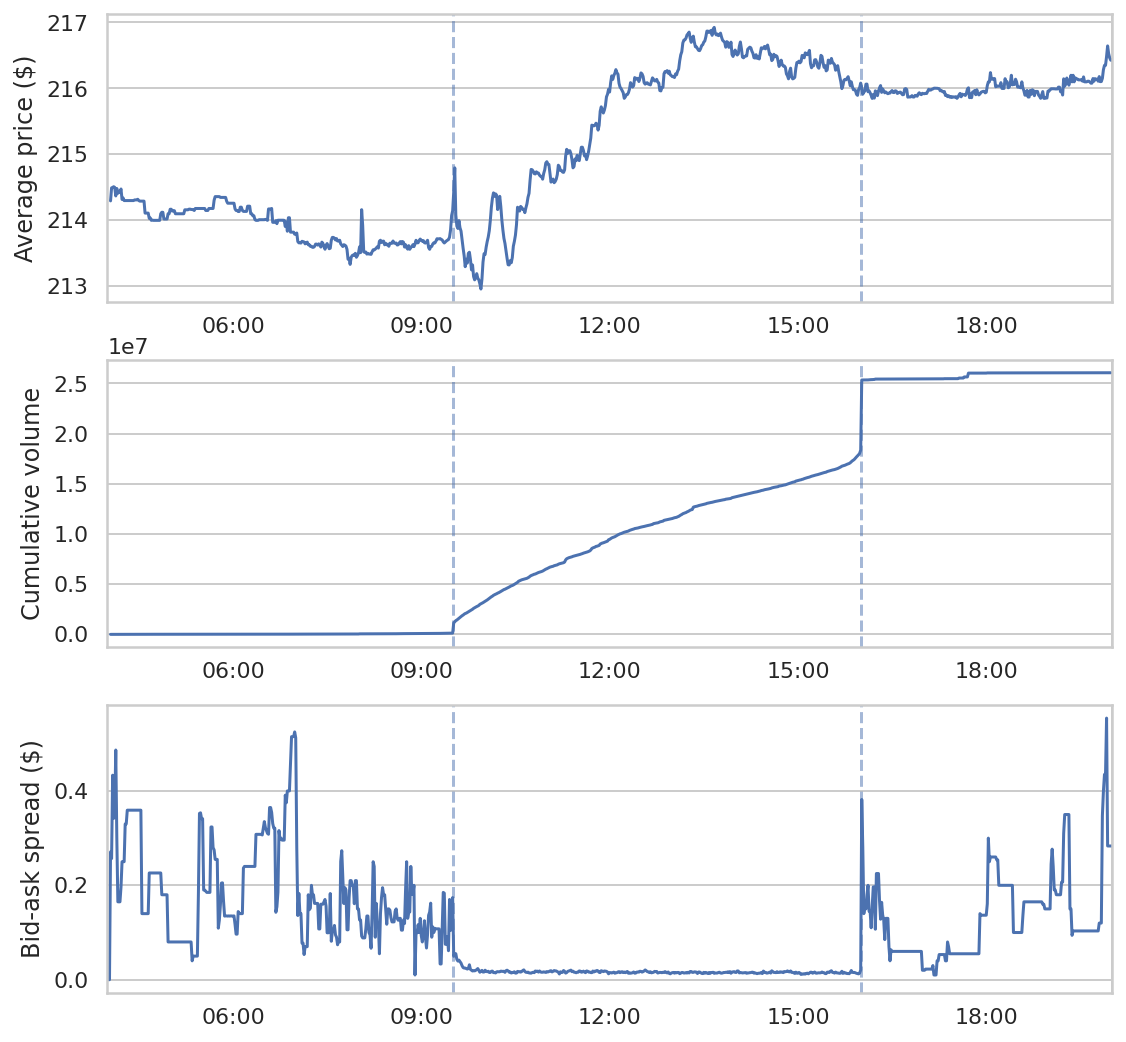

In [44]:
ticker = 'MSFT'
date = datetime.date(2020, 12, 8)
fig, axes = plt.subplots(3, 1, figsize=(9, 9))

# Plot average price of trades.
price_per_minute = data.get_bars(
    ticker, date, 'trades', agg='mean', freq='1min', extended_hours=True
)['price'].fillna(method='ffill')
price_per_minute.plot.line(ax=axes[0], ylabel='Average price ($)')

# Plot comulative volume of trades.
volume_per_minute = data.get_bars(
    ticker, date, 'trades', agg='sum', freq='1min', extended_hours=True
)['volume']
volume_per_minute.cumsum().plot.line(ax=axes[1], ylabel='Cumulative volume')

# Plot bid-ask spread of trades.
bid_ask_spread_per_minute = data.get_bars(
    ticker, date, 'quotes', agg='mean', freq='1min', extended_hours=True
)['spread'].fillna(method='ffill')

bid_ask_spread_per_minute.plot.line(ax=axes[2], ylabel='Bid-ask spread ($)')

# Add indicator for beginning and end of regular trading hours.
for ax in axes:
    for time in [(9, 30), (16, 0)]:
        ax.axvline(
            datetime.datetime.combine(date, datetime.time(*time)), 
            linestyle='--', alpha=0.5
        )

The vast majority of trades happen during regular trading hours from 9:30 AM to 4:00 PM. Therefore, the bid-ask spread, i.e. the loss after buying and immediately selling the stock, is significantly higher outside of regular hours, making it riskier to perform any trades then. In addition, most price shifts happen within regular hours, making it reasonable to focus on this time. 

### 2. When is a buy profitable?

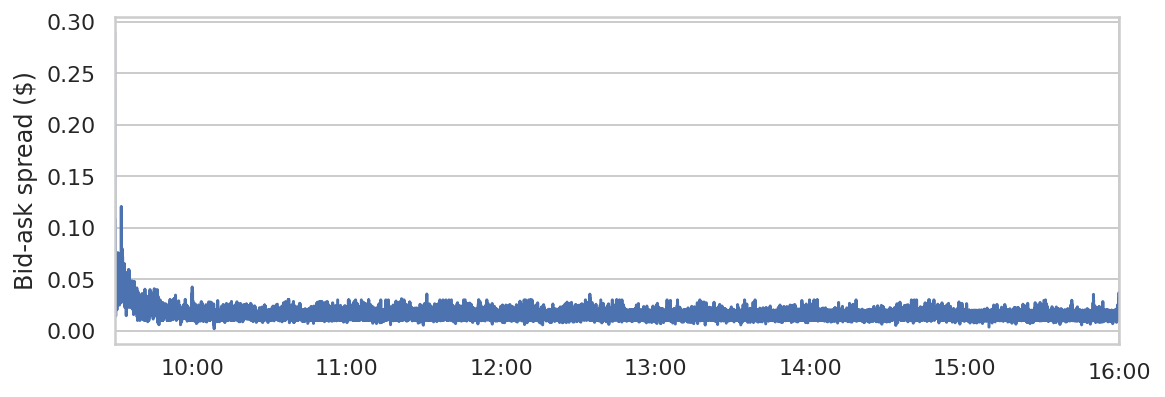

Average bid-ask spread: $0.017


In [53]:
ticker = 'MSFT'
date = datetime.date(2020, 12, 8)

fig, ax = plt.subplots(figsize=(9, 3))

spread = data.get_bars(ticker, date, 'quotes')['spread']
spread.plot.line(ax=ax, ylabel='Bid-ask spread ($)')
plt.show()

print(f'Average bid-ask spread: ${spread.mean():0.3f}')

The average bid-ask spread is less than \\$0.02, staying below \\$0.05 for most of the day with the exception of the first minutes after opening. Using \\$0.05 as a threshold to consider a trade profitable should be a conservative approach as long as a small number of stocks are bought. For now, that value can be used as a rough threshold, but, optimally, before performing any trade the actual current spread should be checked.

### 3. What time scale?

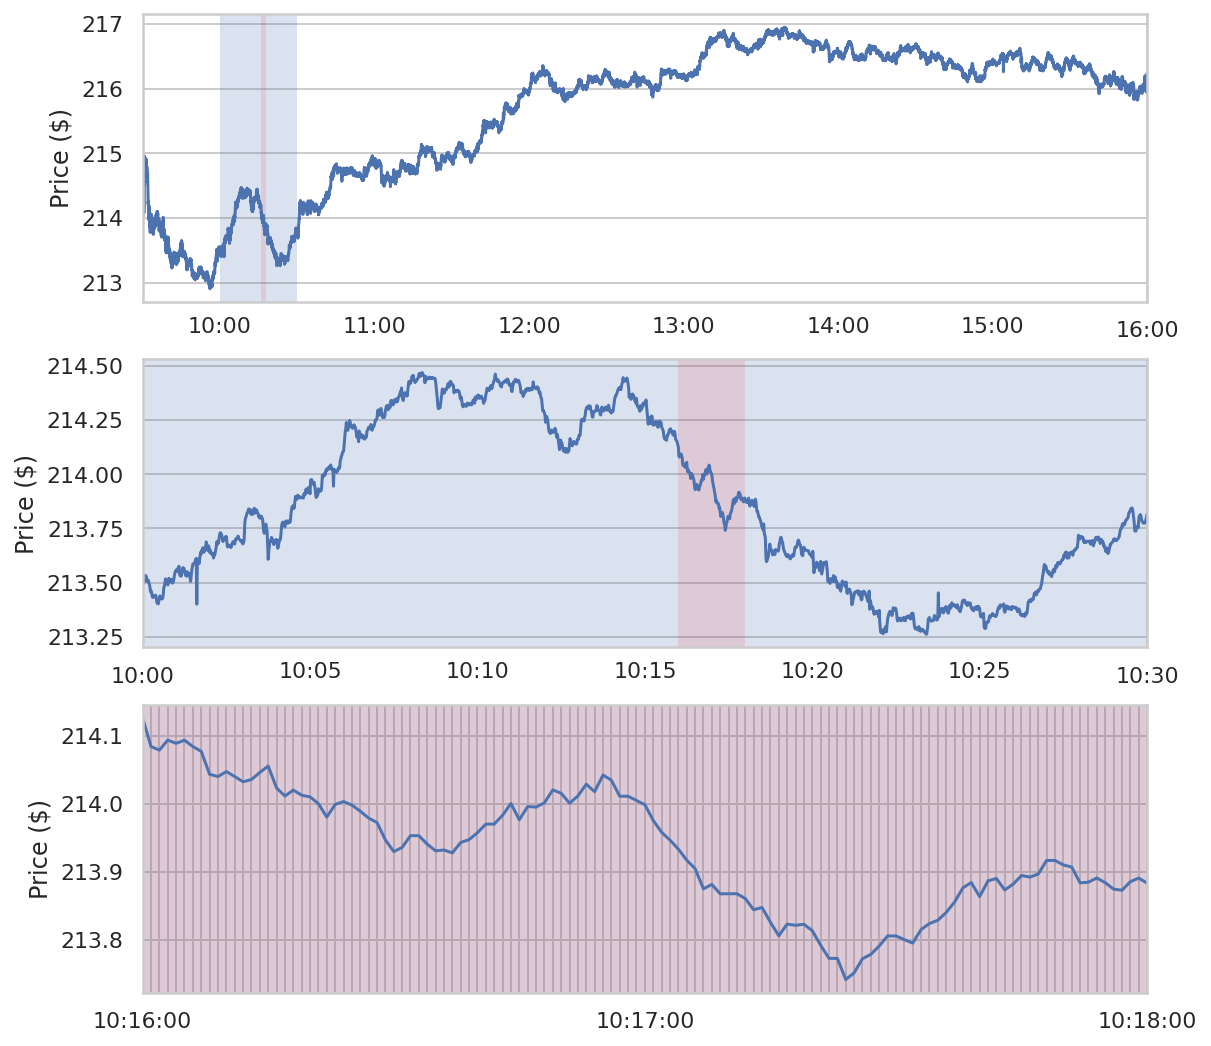

Average trades per second: 9.63


In [62]:
ticker = 'MSFT'
date = datetime.date(2020, 12, 8)
fig, axes = plt.subplots(3, 1, figsize=(9, 9))

# Plot price over the entire day.
price = data.get_bars(ticker, date, freq='1S', fillna=True)['price']
price.plot.line(ax=axes[0], ylabel='Price ($)')

# Plot price over a thirty minute window.
window1 = price.between_time('10:00', '10:30')
window1.plot.line(ax=axes[1], ylabel='Price ($)')

# Plot price over a two minute window.
window2 = price.between_time('10:16', '10:18')
window2.plot.line(ax=axes[2], ylabel='Price ($)')
axes[2].xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=1))

# Shade in time windows.
for ax in axes:
    ax.axvspan(*window1.index[[0, -1]], alpha=0.2, lw=0)
    ax.axvspan(*window2.index[[0, -1]], color='red', alpha=0.1, lw=0)

plt.show()
trades_per_second = data.get_bars(ticker, date, agg='count', freq='1S')['price']
print(f'Average trades per second: {trades_per_second.mean():0.2f}')

Prices swings exceeding the set \\$0.05 bid-ask spread threshold happen often at the timescale of seconds. Most of the increases above the threshold happens over more than 10 seconds, making it unnecessary to capture nuances at a smaller interval than every second. 

## Target classification: when to buy and sell

Each timepoint should be classified as `buy` or `sell` based on its price changes. Time periods where the price increases more than \\$0.05 should be labeled as `buy`. Time periods where the price decreases should be labeled as `sell`. Small price fluctuations should not interrupt price runs.

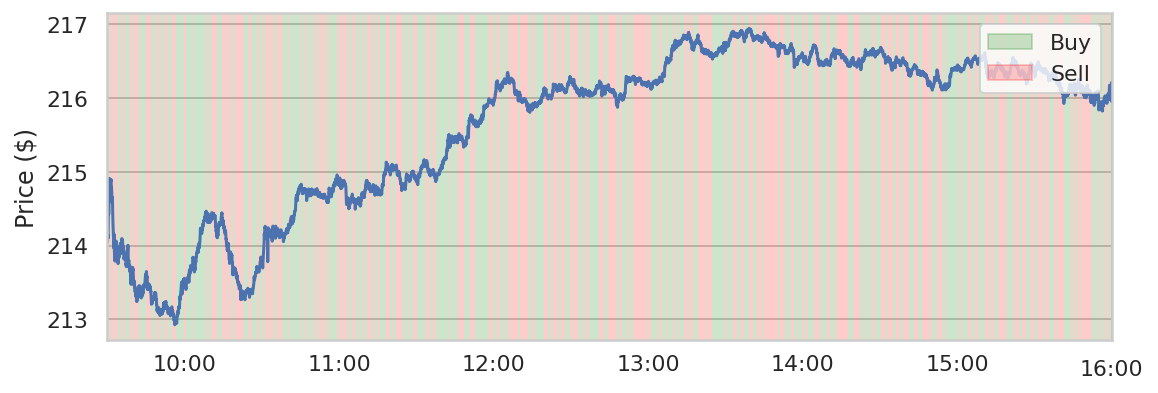

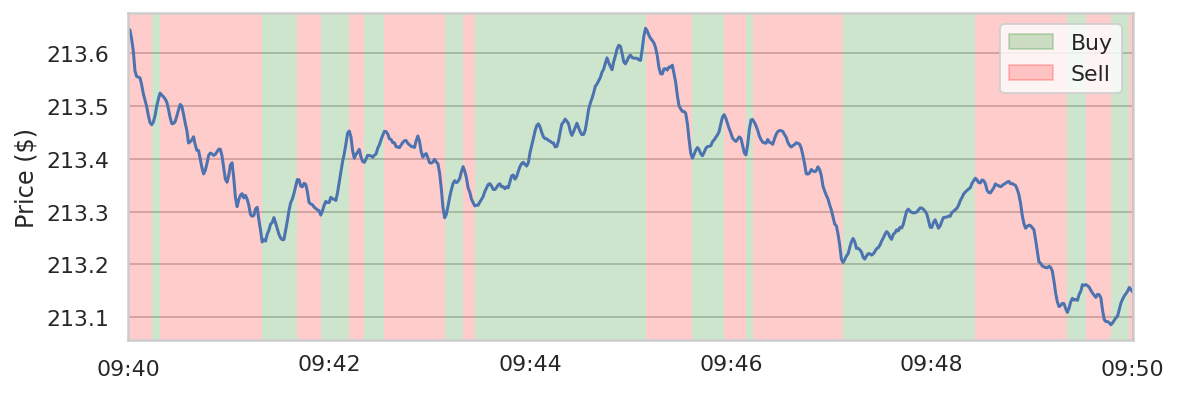

Number of buys: 239
Active gain: 10.82%
Passive gain: 0.83%


In [75]:
ticker = 'MSFT'
date = datetime.date(2020, 12, 8)

# How many period into the past should the current price be smoothed by to
# reduce low-level noise? More smoothing is less risky.
periods_to_smooth_price = 3

# How much, in dollars, does a stock have to gain while its held for the
# transaction to be profitable. A higher estimate is less risky.
gain_threshold = 0.05

# Get price aggregates per second.
price = data.get_bars(
    ticker, date, agg='weighted_mean', smooth_periods=periods_to_smooth_price, fillna=True
)

# Label long ups as buy, and long downs as sell.
params = {'periods_to_smooth_by': periods_to_smooth_price, 'gain_threshold': gain_threshold}
label = target.label_buy_or_sell(ticker, date, params)
target.plot_timeseries(price, label)
target.plot_timeseries(price.between_time('9:40', '9:50'), label.between_time('9:40', '9:50'))

# Calculate hypothetical gains.
profits = target.profits(price, label, buy_cost=gain_threshold)
print(f'Number of buys: {profits["total_buys"]}')
print(f'Active gain: {profits["active_gain"]*100:.2f}%')
print(f'Passive gain: {profits["passive_gain"]*100:.2f}%')

An all-knowing investor would be able to gain more than 10% over a single day, compared to passive investors, who would gain less than 1%. Those numbers are motivating, but we are unfortunately not all-knowing.

## Feature engineering

Features need to be generated for every second during open hours. Features include descriptive stats of recent trades and different measures describing changes to these stats. Generated features are stored to disk, as they can take a while to generate. Features are generated one day at a time to allow caching the day's trades in the memory.


### Initial features

- **Top recent trades**: Looking at trades that happened recently, what are the top trades in terms of price and volume, and how long ago did the trade happen? 
    
- **Trade stats of the current bar**: Descriptive stats of trades happening now (within the last second). Includes the mean, median, min, max, and standard deviation of price, volume, and price-adjusted volume (price * volume).

- **Current bar compared to rolling average**: The relative changes in the current stats compared to a preceding time window. The time window varies from 3 seconds into the past to the beginning of the day (but currently not any previous days).

- **Current price compared to previous high and low**: The relative change price compared to the high and low of a preceding time window. The time window varies from 1 minute into the past to the beginning of the day (but currently not any previous days).

- **Current price compared to the beginning of larger bars**: The relative change in the price compared to the beginning of the minute, hour, day, and a few frequencies in between.

- **Trade stats of recent bars**: Descriptive stats of trades that happened during recent time periods (compared to now) going back a defined number of seconds.

- **Changes to stats of recent bars**: The change in stats for recent time periods (compared to bar preceding it) going back a defined number of seconds.

- **Proportion of recent bars that increased**: The proportion of times in a preceding time window that saw an increase in price or volume (considered separately). The time window varies from 1 second into the past to the beginning of the day.

- **Number of consequtive bars that increased**: How far into the past the price or volume (considered separately) has been increasing after applying a moving average smoothening. The moving average time window varies from 1 second to 30 minutes.

- **Current time and date**: The second, minute, and hour of the day, as well the day of the week, month, quarter, and year.

- **Time since and until the beginning of a significant period**: The seconds since trading started for the day and until trading closes for the day (may be different on half-days after holidays), as well as the number of business days since the first business day and until the last business day of the month, quarter, and year.

- **Time since holiday**: The number days since the last holiday causing exchanges to be closed when it would have otherwise been open. Also includes whether a day is a half-day where the exchanges closes early due to a holiday (e.g. the day after Thanksgiving).

In [76]:
ticker = 'MSFT'
features = feature_manager.FeatureManager(ticker)

features.add_many([
    (
        'Target',
        target.label_buy_or_sell,
        {'gain_threshold': 0.05},
    ),
    (
        'Top recent trades',
        trade_properties.top_recent_trades,
        {'num_of_trades': 100, 'num_of_top_trades': 10},
    ), 
    (
        'Trade stats of the current bar',
        bar_properties.current_bar_stats,
    ), 
    (
        'Current bar compared to rolling average',
        bar_changes.current_bar_compared_to_rolling,
    ), 
    (
        'Current price compared to previous high and low',
        bar_changes.current_bar_compared_to_high_and_low,
    ), 
    (
        'Current price compared to the beginning of larger bars',
        bar_changes.current_bar_compared_to_open,
    ), 
    (
        'Trade stats of recent bars',
        bar_changes.recent_bars_compared_to_current,
        {'periods_to_go_back': 60},
    ), 
    (
        'Changes to stats of recent bars',
        bar_changes.recent_bars_compared_to_preceding,
        {'periods_to_go_back': 60},
    ), 
    (
        'Proportion of recent bars that increased',
        bar_changes.proportion_of_increasing_bars,
    ), 
    (
        'Number of consequtive bars that increased',
        bar_changes.consecutive_of_increasing_bars,
    ), 
    (
        'Current time and date',
        times.current_time_and_date,
    ), 
    (
        'Time since and until the beginning of a significant period',
        times.time_since_and_until_start_of,
    ), 
    (
        'Time since holiday',
        times.time_since_holiday,
    )
])

features.generate('2019-11-01', '2020-12-31')

13:49:15 Feature generation started.
100%|██████████| 294/294 [00:00<00:00, 406837.80it/s]
13:49:15 Feature generation completed.


### Addition feature ideas

- Technical indicators.
- Comparing prices/volumes across different days.
- Stats on bid-ask spread.
- Relevant news articles.
- Mentions on social networks.

## Hyperparameter tuning

The best hyperparameters are searched for by first using a random approach to broadly sample hyperparameter space. If the search results in a significant bump in performance, a more thorough grid search is then performed.

### Initial randomized parameter search
The data is sampled to one month of trades for training the model, ensuring everything can fit in memory. To decrease bias towards the sample, three models are trained on three different time periods for each parameter set. 

In [8]:
ticker = 'MSFT'

number_of_iterations = 100
random_search_save_path = 'models/random_search'

sample_dates = [
    {'train': ('2020-03-01', '2020-03-31'), 'test': ('2020-04-01',)},
    {'train': ('2020-09-09', '2020-10-08'), 'test': ('2020-10-09',)},
    {'train': ('2020-11-28', '2020-12-27'), 'test': ('2020-12-28',)},
]

param_grid = {
    'max_depth': [3, 10, 30, 100, None],
    'min_samples_leaf': [3, 10, 30, 100, 300, 1000],
    'min_samples_split': [10, 30, 100, 300, 1000, 3000, 10000],
    'max_samples': [0.01, 0.03, 0.1, 0.3, None],
    'n_estimators': [30, 100, 300],
}

def get_base_model(params):
    return sklearn.ensemble.RandomForestClassifier(
        n_jobs=15, random_state=1, criterion='gini', max_features='sqrt', 
        bootstrap=True, **params
    )

# Randomize parameters
random.seed(0)
random_params = [{}]  # first model is base model
for i in range(number_of_iterations-1):
    params = {}
    while params in random_params:
        for param_name, param_values in sorted(param_grid.items()):  # sort to ensure random consistency
            params[param_name] = random.choice(param_values)
    random_params.append(params)

# Fit and save model.
logging.info('Started randomized parameter search.')
with tqdm(total=len(sample_dates) * number_of_iterations) as progess_bar:
    for sample_i, dates in enumerate(sample_dates): 
        train_Xy = data.get_features(ticker, *dates['train'])
        for iteration in range(number_of_iterations):
            progess_bar.update(1)
            params = random_params[iteration]
            model_path = os.path.join(
                random_search_save_path,
                f'{iteration}_{sample_i}_{utils.serialize_dict(params)}.pkl'
            )
            if not os.path.exists(model_path):
                continue
            model = get_base_model(params)
            model.fit(*train_Xy)
            joblib.dump(model, model_path)
            
            del model
            
        del train_Xy
        
logging.info('Parameter search complete.')

15:17:08 Started randomized parameter search.
100%|██████████| 300/300 [00:30<00:00,  9.96it/s]
15:17:38 Parameter search complete.


### Analysis of initial randomized parameter search

Each model is tested on the business day following the training period.

In [3]:
feature_id_to_name = data.db.feature_ids_to_names(ticker)

random_search_results = {}
with tqdm(total=len(sample_dates) * number_of_iterations) as progess_bar:
    for sample_i, dates in enumerate(sample_dates):
        train_Xy = data.get_features(ticker, *dates['train'])
        test_Xy = data.get_features(ticker, *dates['test'])
        for iteration in range(number_of_iterations):
            progess_bar.update(1)
            params = random_params[iteration]

            result = random_search_results.get(
                iteration, collections.defaultdict(list, params=params)
            )
            model_path = os.path.join(
                random_search_save_path,
                f'{iteration}_{sample_i}_{utils.serialize_dict(params)}.pkl'
            )
            result['names'].append(model_path)

            model = joblib.load(model_path)
            for train_or_test, (X, y) in [('train', train_Xy), ('test', test_Xy)]:
                y_pred = model.predict(X)
                for score in (
                    sklearn.metrics.accuracy_score,
                    sklearn.metrics.precision_score,
                    sklearn.metrics.recall_score,
                    sklearn.metrics.f1_score
                ):
                    result[f'{train_or_test}_{score.__name__}'].append(score(y, y_pred))
                X = X.rename(feature_id_to_name, axis=1)

                profits = target.profits(
                    X['trade_stats_of_the_current_bar__price'],
                    y_pred,
                    buy_cost=0.05
                )
                result[f'{train_or_test}_profits'].append(
                    profits['active_gain'] - profits['passive_gain']
                )

            random_search_results[iteration] = result

del train_Xy, test_Xy, X, y, y_pred, model

100%|██████████| 300/300 [39:02<00:00,  7.81s/it] 


In [4]:
base_model = random_search_results[0]
best_model = base_model
for model in random_search_results.values():
    if np.mean(model['test_accuracy_score']) > np.mean(best_model['test_accuracy_score']):
        best_model = model

print(
    f'Base model - {base_model["params"]}\n'
    f'train scores: {base_model["train_accuracy_score"]}\n'
    f'test scores: {base_model["test_accuracy_score"]}'
)
print(
    f'Best random model - {best_model["params"]}\n'
    f'train scores: {best_model["train_accuracy_score"]}\n'
    f'test scores: {best_model["test_accuracy_score"]}'
)

for i, name in enumerate(best_model['names']):
    shutil.copyfile(f'{model_path}/{name}.pkl', f'{model_path}/best_model_{i}.pkl')

Base model - {}
train scores: [0.9999941727432006, 0.9999961151621337, 0.9999976948911873]
test scores: [0.7670612366992864, 0.7286868082560575, 0.6897141147814196]
Best random model - {'max_depth': 100, 'max_samples': 0.3, 'min_samples_leaf': 30, 'min_samples_split': 300, 'n_estimators': 100}
train scores: [0.7922641223568534, 0.7550065848001833, 0.743814816778426]
test scores: [0.7687705653604546, 0.7313362676808683, 0.6995000213666083]



:: 2020-04-01 :: 
Passive gain: -0.58% 
Possible active gain: 62.92% (690 buys) 
Predicted active gain: -3.30% (2122 buys) 

Optimal:


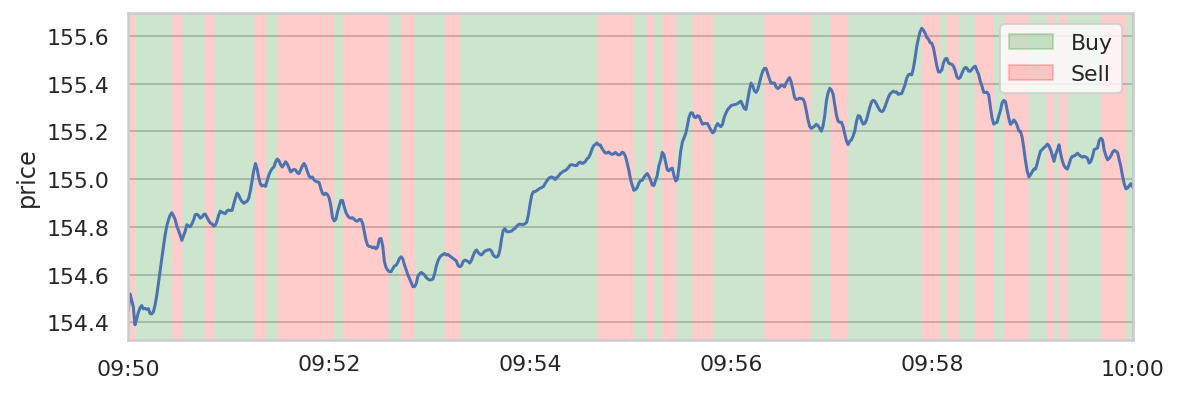

Predicted:


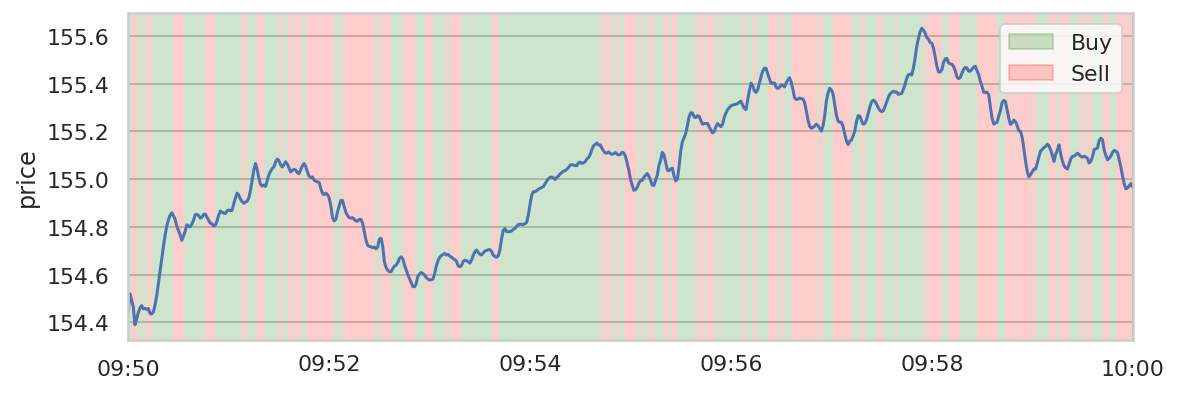


:: 2020-12-28 :: 
Passive gain: 0.26% 
Possible active gain: 6.97% (230 buys) 
Predicted active gain: -15.38% (1361 buys) 

Optimal:


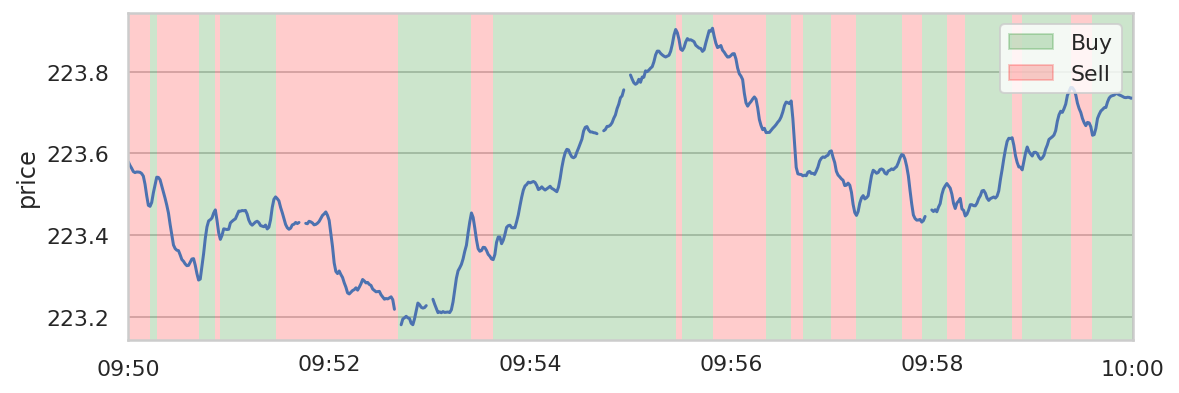

Predicted:


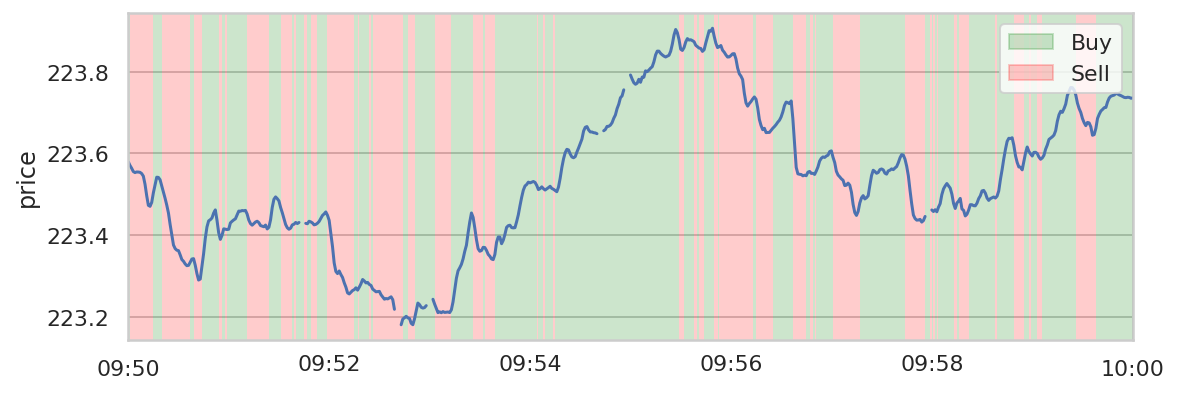

In [5]:
for cv in [0, 2]:
    test_date = test_dates[cv]
    model = joblib.load(f'{model_path}/best_model_{cv}.pkl')

    df = data.get_bars(
        ticker, test_date, agg='weighted_mean', smooth_periods=3
    ).rename('price').to_frame()

    df['prediction'] = model.predict(get_test(cv)[0])
    df['actual'] = get_test(cv)[1]

    profits_actual = target.profits(df['price'], df['actual'], buy_cost=0.05)
    profits_prediction = target.profits(df['price'], df['prediction'], buy_cost=0.05)
    print(
        f'\n:: {test_date} :: \n'
        f'Passive gain: {profits_actual["passive_gain"]*100:.2f}% \n'
        f'Possible active gain: {profits_actual["active_gain"]*100:.2f}% '
        f'({profits_actual["total_buys"]} buys) \n'
        f'Predicted active gain: {profits_prediction["active_gain"]*100:.2f}% '
        f'({profits_prediction["total_buys"]} buys) \n'
    )
    print('Optimal:')
    target.plot_timeseries(df.between_time('9:50', '10:00'), 'price', 'actual')
    print('Predicted:')
    target.plot_timeseries(df.between_time('9:50', '10:00'), 'price', 'prediction')

Looking at the buy-sell plot, some periods are correctly predicted, which is promising. However, these periods are frequently interrupted short break, resulting in many more buys than what is optimal.

More concerning is that both the base model _and_ the optimal model from the randomized hyperparameter search are significantly overfit, performing perfectly on the training set and equally bad on the test set. Which hyperparameters have the potential to reduce the fit on the training data without negatively affecting the git on the test data?

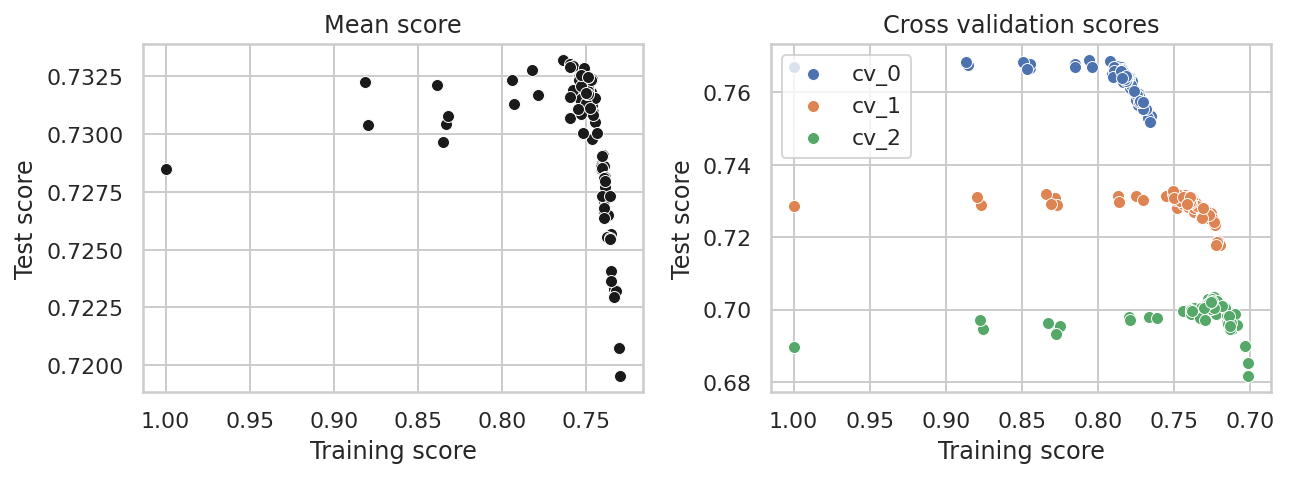

In [20]:
df_rows = []
for _, result in sorted(random_search_results.items()):
    df_rows.append({
        'mean_train_score': np.mean(result['train_accuracy_score']),
        'mean_test_score': np.mean(result['test_accuracy_score']),
        **{f'train_{i}': score for i, score in enumerate(result['train_accuracy_score'])},
        **{f'test_{i}': score for i, score in enumerate(result['test_accuracy_score'])},
        **result['params'],
    })
search_results_df = pd.DataFrame(df_rows)
search_results_df = search_results_df[search_results_df['mean_train_score'] > 0.6]
    
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
sns.scatterplot(
    ax=axes[0], data=search_results_df, x='mean_train_score', y='mean_test_score', color='k'
)
for cv in range(3):
    sns.scatterplot(
        ax=axes[1], data=search_results_df, x=f'train_{cv}', y=f'test_{cv}',
        label=f'cv_{cv}'
    )
axes[0].set_title('Mean score')
axes[1].set_title('Cross validation scores')
for ax in axes:
    ax.invert_xaxis()
    ax.set_ylabel('Test score')
    ax.set_xlabel('Training score')
fig.tight_layout()

The hyperparameter results in training scores down to 0.7 without significanly impacting test scores. These parameters will serve as a base for another round of randomized hyperparameter search.

Furthermore, a large variation is seen in tests scores for different cross validation rounds. Since each round consists of a different training data size, it is likely that the training data is a limiting factor. The round with the most training data performed the best. As not more training data fits compfortably in the memory, it will have to be loaded directly from disk as the forest is built.

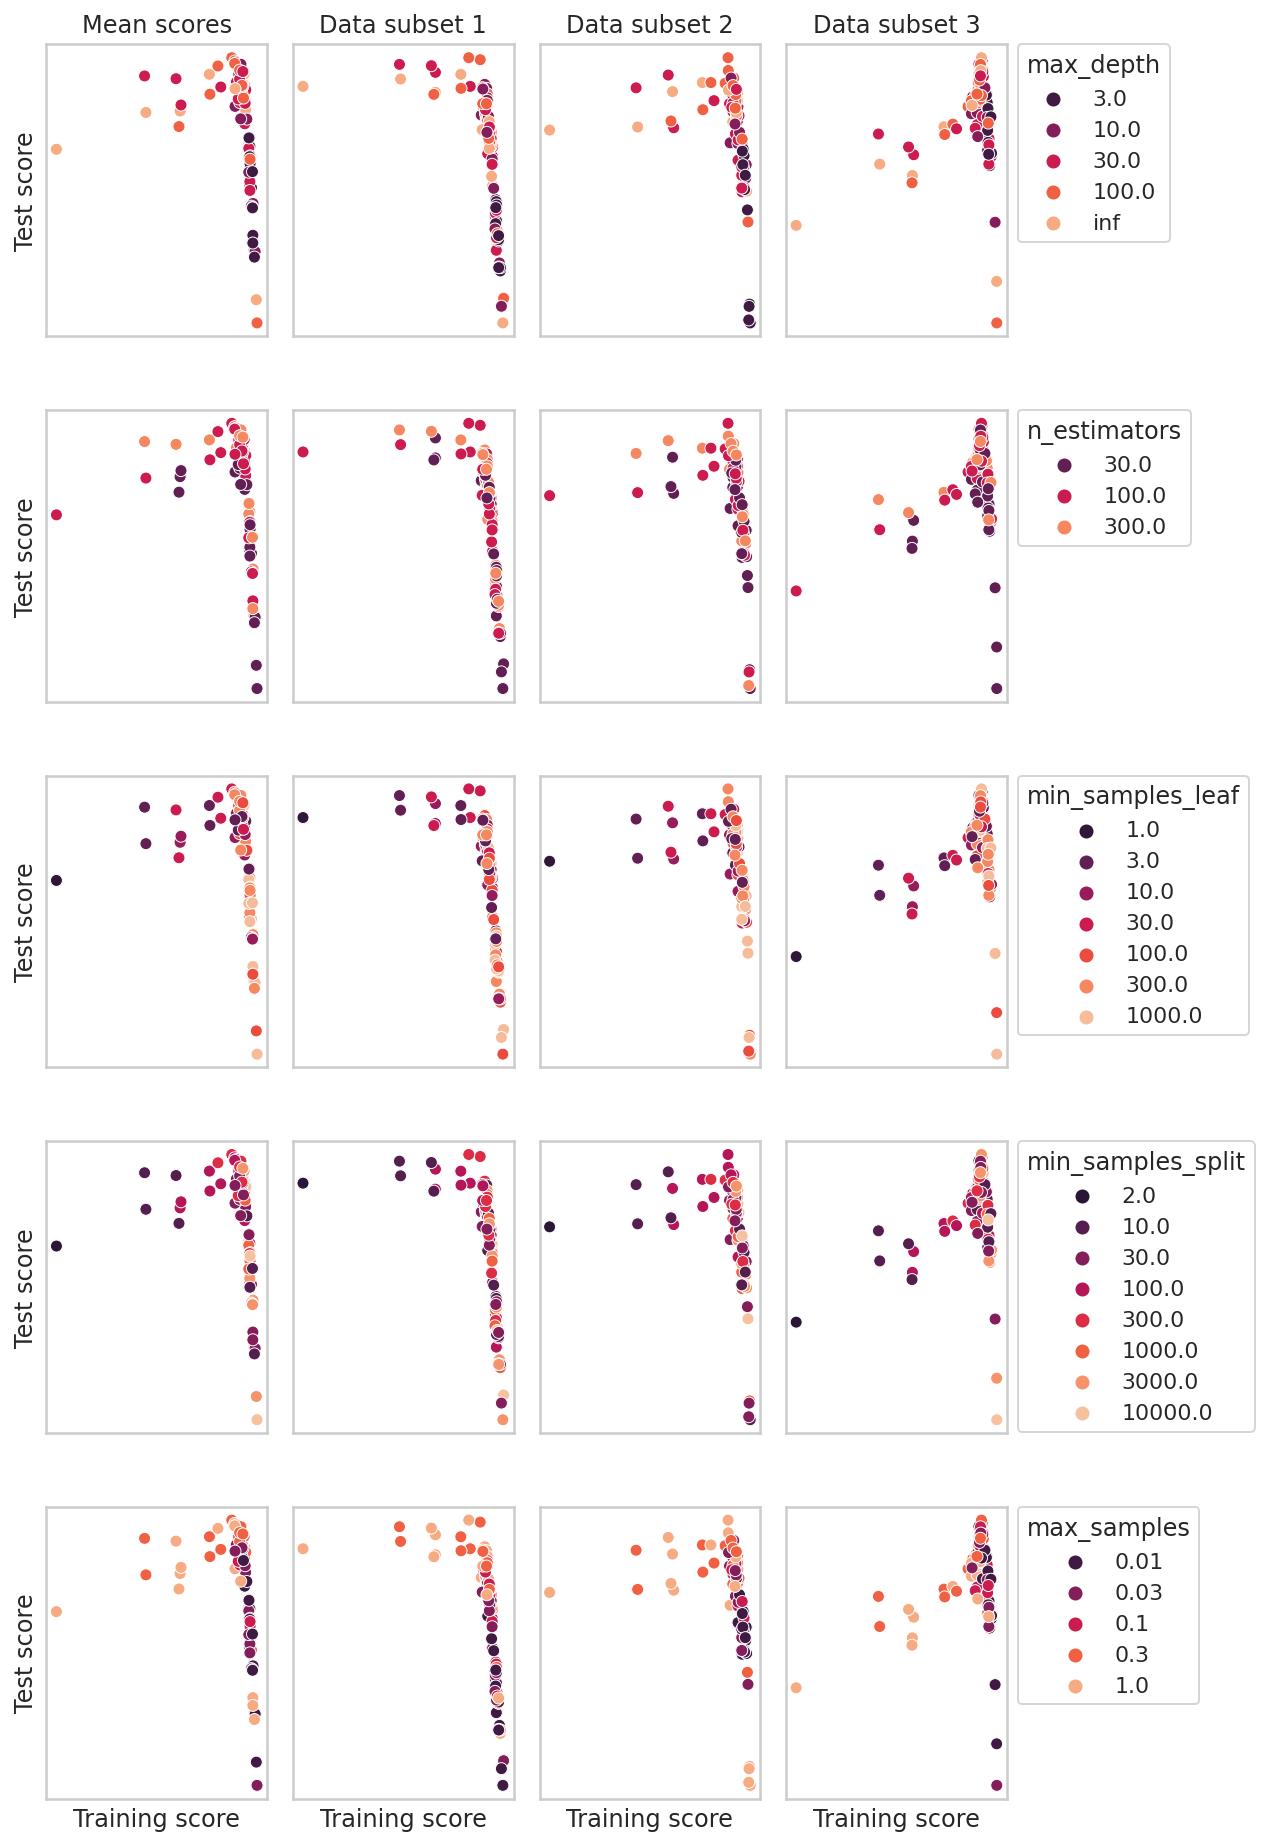

In [23]:
fig, axes = plt.subplots(5, 4, figsize=(9, 13))
axes = axes.flatten()
parameters = ['max_depth', 'n_estimators', 'min_samples_leaf', 'min_samples_split', 'max_samples']

# Set detault parameters for visualization.
search_results_df['max_depth'] = search_results_df['max_depth'].fillna(np.inf)
search_results_df.loc[0, 'n_estimators'] = 100
search_results_df.loc[0, 'min_samples_leaf'] = 1
search_results_df.loc[0, 'min_samples_split'] = 2
search_results_df['max_samples'] = search_results_df['max_samples'].fillna(1)

i = 0
sns.color_palette("rocket", as_cmap=True)
for parameter in parameters:
    hue = search_results_df[parameter].astype(str)
    to_plot = ['mean_train_score', 'train_0', 'train_1', 'train_2']
    for x in to_plot:
        y = x.replace('train', 'test')
        sns.scatterplot(
            ax=axes[i], data=search_results_df, x=x, y=y,
            hue=hue, 
            hue_order=sorted(hue.unique(), key=lambda x: float(x if x != 'nan' else -1)),
            legend=('auto' if x == 'train_2' else False), palette='rocket'
        )
        i += 1

for i, ax in enumerate(axes):
    ax.invert_xaxis()
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('Test score' if i % 4 == 0 else '')
    ax.set_xlabel('Training score' if i > 15 else '')
    if i % 4 == 3:
        ax.legend(title=parameters[i // 4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    if i == 0:
        ax.set_title(f'Mean scores')
    if 0 < i < 4:
        ax.set_title(f'Data subset {i}')

fig.tight_layout()

From the third cross-validation, the best-performing parameters are `maxdepth = 50`, `min_samples_leaf = 5`, and `min_samples_split = 100`. The second round of randomized parameter search will center on these values.

### Determining calendar trends in model prediction performance

In [3]:
ticker = 'MSFT'

params = {
    'max_depth': 100,
    'min_samples_leaf': 30,
    'min_samples_split': 300,
    'max_samples': 0.3,
    'n_estimators': 100,
}

model_path = 'models/calendar_test'

dates_with_trades = data.get_open_dates(ticker, '2020-01-01', '2020-12-31')
for date in tqdm(dates_with_trades):
    
    if os.path.exists(f'{model_path}/{date}.pkl'):
        continue

    train = data.get_features(
        ticker, 
        date - datetime.timedelta(days=31), 
        date - datetime.timedelta(days=1)
    )
    test = data.get_features(ticker, date)
    
    model = get_base_model(params)
    model.fit(train.iloc[:, 1:], train.iloc[:, 0])
    joblib.dump(model, f'{model_path}/{date}.pkl')


    del model
    get_train.cache_clear()
    get_test.cache_clear()


100%|██████████| 253/253 [2:32:12<00:00, 36.10s/it]  


100%|██████████| 253/253 [06:18<00:00,  1.50s/it]

03:37:53 findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


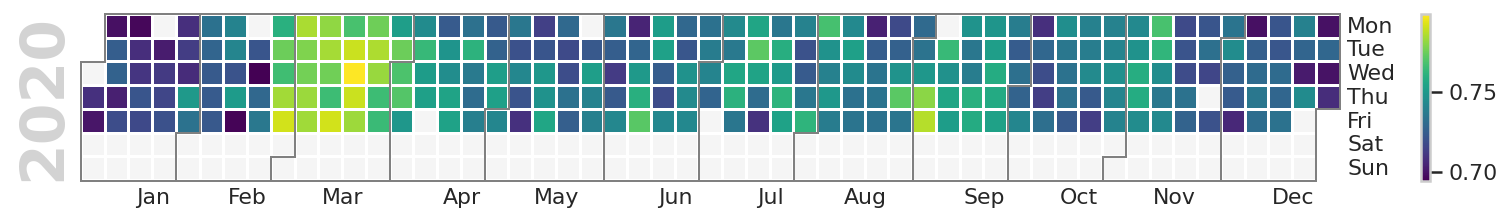

In [4]:
daily_model_results = pd.DataFrame(
    index=dates_with_trades, 
    columns=['scores', 'profits', 'total_buys'],
    dtype=float
)

for date in tqdm(dates_with_trades):
    if not os.path.exists(f'{model_path}/{date}.pkl'):
        continue
        
    prices = data.get_bars(
        ticker, date, agg='weighted_mean', smooth_periods=3
    ).rename('price')
    
        
    model = joblib.load(f'{model_path}/{date}.pkl')
    test = data.get_features(ticker, date)
    test_X = test.iloc[:, 1:]
    test_y = test.iloc[:, 0]
    
    prediction = model.predict(test_X)
    profit_actual = target.profits(prices, prediction, buy_cost=0.05)
    profit_optimal = target.profits(prices, test_y, buy_cost=0.05)
    
    daily_model_results.loc[date] = {
        'scores': sklearn.metrics.accuracy_score(test_y, prediction),
        'profits': profit_actual['active_gain'] - profit_actual['passive_gain'],
        'total_buys': profit_optimal['total_buys'],
    }
    
del model
get_test.cache_clear()

print('')
daily_model_results.index = pd.to_datetime(daily_model_results.index)
calplot.calplot(daily_model_results['scores']);

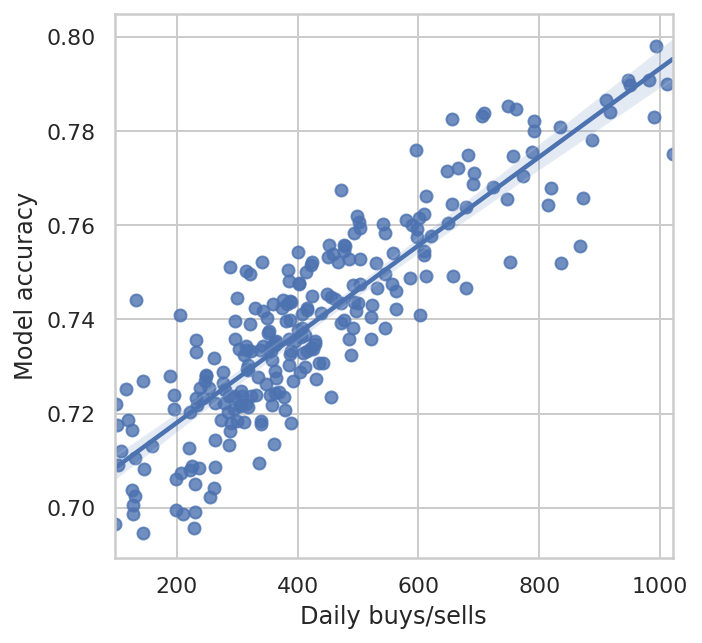

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x='total_buys', y='scores', data=daily_model_results)
ax.set_xlabel('Daily buys/sells')
ax.set_ylabel('Model accuracy')
plt.show()


:: 2020-02-19 :: 
Passive gain: -0.42% 
Possible active gain: 4.84% (144 buys) 
Predicted active gain: -18.35% (1231 buys) 

Optimal:


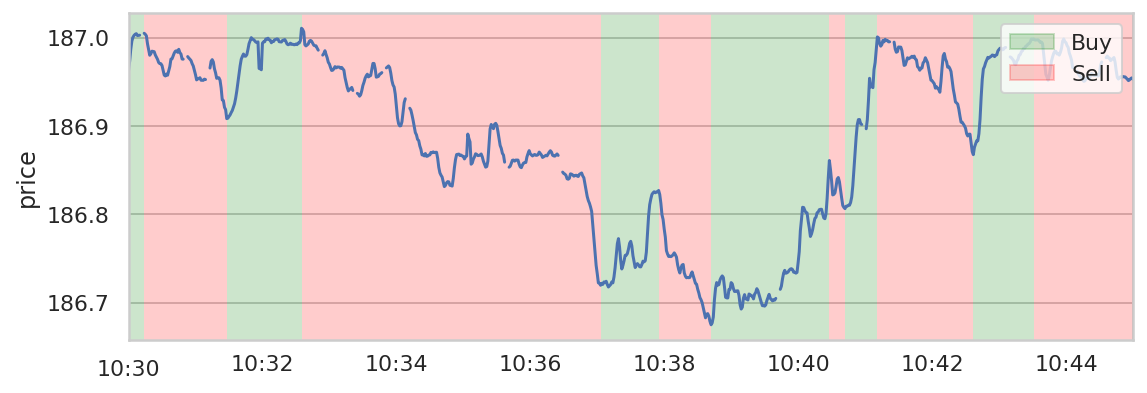

Predicted:


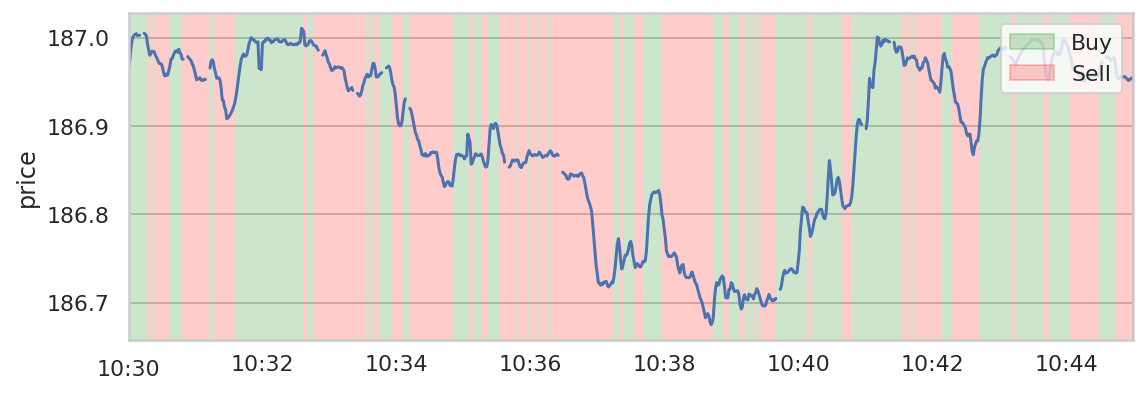


:: 2020-03-18 :: 
Passive gain: 4.08% 
Possible active gain: 407.31% (994 buys) 
Predicted active gain: 136.56% (2469 buys) 

Optimal:


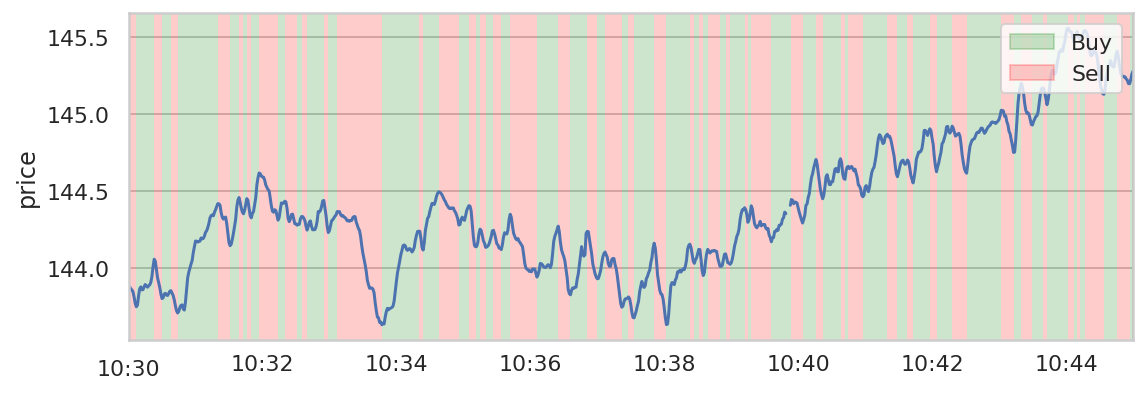

Predicted:


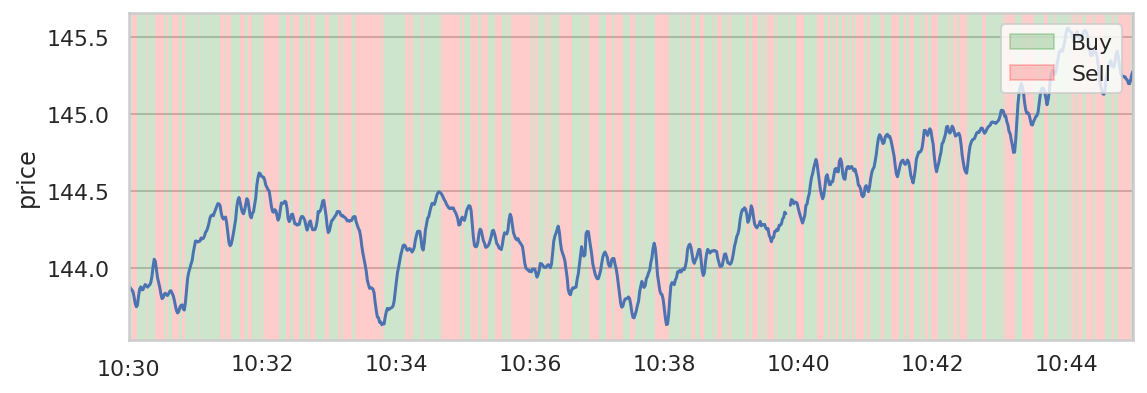

In [8]:
best_performance = daily_model_results.index[daily_model_results['scores'].argmax()].date()
worst_performance = daily_model_results.index[daily_model_results['scores'].argmin()].date()

for date in (worst_performance, best_performance):
    model = joblib.load(f'{model_path}/{date}.pkl')

    df = data.get_bars(
        ticker, date, agg='weighted_mean', smooth_periods=3
    ).rename('price').to_frame()

    
    test = data.get_features(ticker, date)
    test_X = test.iloc[:, 1:]
    test_y = test.iloc[:, 0]
    df['prediction'] = model.predict(test_X)
    df['actual'] = test_y

    profits_actual = target.profits(df['price'], df['actual'], buy_cost=0.05)
    profits_prediction = target.profits(df['price'], df['prediction'], buy_cost=0.05)
    print(
        f'\n:: {date} :: \n'
        f'Passive gain: {profits_actual["passive_gain"]*100:.2f}% \n'
        f'Possible active gain: {profits_actual["active_gain"]*100:.2f}% '
        f'({profits_actual["total_buys"]} buys) \n'
        f'Predicted active gain: {profits_prediction["active_gain"]*100:.2f}% '
        f'({profits_prediction["total_buys"]} buys) \n'
    )
    print('Optimal:')
    target.plot_timeseries(df.between_time('10:30', '10:45'), 'price', 'actual')
    print('Predicted:')
    target.plot_timeseries(df.between_time('10:30', '10:45'), 'price', 'prediction')
    
    del model, test

## Feature pruning

In [10]:
ticker = 'MSFT'

feature_names = list(zip(*sorted(data.db.feature_ids_to_names(ticker).items())))[1][1:]
feature_importance = pd.DataFrame(index=feature_names)

for date in tqdm(dates_with_trades):

    model = joblib.load(f'models/calendar_test/{date}.pkl')
    feature_importance[i] = model.feature_importances_

feature_importance['mean'] = feature_importance.mean(axis=1)

100%|██████████| 253/253 [00:34<00:00,  7.32it/s]


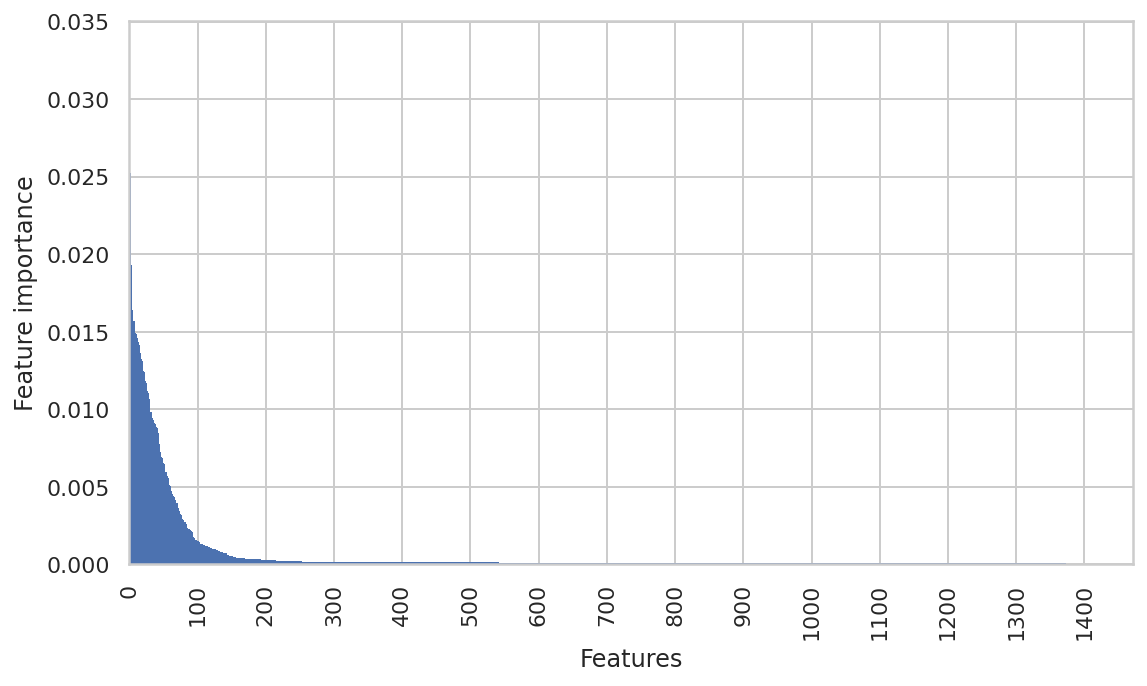

In [11]:
fig, ax = plt.subplots(figsize=(9, 5))
ax = feature_importance.sort_values('mean', ascending=False)['mean'].plot.bar(ax=ax, width=1, lw=0)
ax.set_xticks(range(0, feature_importance.shape[0], 100))
ax.set_xticklabels(range(0, feature_importance.shape[0], 100))
ax.set_xlabel('Features')
ax.set_ylabel('Feature importance')
plt.show()

Ideas:

- Add feature that describes how many local minima and maxima there has been recently, and the price steps between them.
- Prune weak features
- PCA

Add:

- disclaimer